# Parquet Storage from Stored Kerchunk JSON Files

Scan a collection of SalishSeaCast netCDF files to create a collection of Kerchunk reference JSON files
Then combine those references to create a combined reference for a virtual dataset for the collection
stored as a `Parquet` storage structure instead of `json`.
`Parquet` should make the combined reference storage smaller and its use to access the netCDF dataset
files use less memory.
Finally,
demonstrate access to arbitrary slices in the collection.
This notebook is based on information learned from the notebooks in Project Pythia Kerchunk Cookbook.

ref: https://zenodo.org/badge/latestdoi/588661659

In [6]:
import os
from pathlib import Path
import shutil

import arrow
import fsspec
import kerchunk.combine
import kerchunk.hdf
import ujson
import xarray

Generate a list of netCDF file paths to create Kerchunk references for:

In [2]:
results_archive = Path("/results2/SalishSea/nowcast-green.202111/")

start_date, end_date = arrow.get("2007-05-15"), arrow.get("2023-05-15")

nc_paths = []
for day in arrow.Arrow.range("year", start_date, end_date):
    ddmmmyy = day.format("DDMMMYY").lower()
    yyyymmdd = day.format("YYYYMMDD")
    nc_paths.append(results_archive / ddmmmyy / f"SalishSea_1h_{yyyymmdd}_{yyyymmdd}_grid_T.nc")

nc_paths

[PosixPath('/results2/SalishSea/nowcast-green.202111/15may07/SalishSea_1h_20070515_20070515_grid_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/15may08/SalishSea_1h_20080515_20080515_grid_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/15may09/SalishSea_1h_20090515_20090515_grid_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/15may10/SalishSea_1h_20100515_20100515_grid_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/15may11/SalishSea_1h_20110515_20110515_grid_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/15may12/SalishSea_1h_20120515_20120515_grid_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/15may13/SalishSea_1h_20130515_20130515_grid_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/15may14/SalishSea_1h_20140515_20140515_grid_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/15may15/SalishSea_1h_20150515_20150515_grid_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/15

Function to generate Kerchunk reference .json file for a specified netCDF file and store the
reference file is a specified directory with the same file name stem as the netCDF file:

In [3]:
def generate_json_reference(nc_path, refs_dir):
    with fsspec.open(nc_path) as nc_file:
        h5chunks = kerchunk.hdf.SingleHdf5ToZarr(nc_file, os.fspath(nc_path))
        ref_file_name = f"{nc_path.stem}.json"
        with (refs_dir / ref_file_name).open("wb") as ref_file:
            ref_file.write(ujson.dumps(h5chunks.translate()).encode())
        return ref_file_name

Create the directory where the reference files will be stored:

In [4]:
refs_dir = Path("references")
refs_dir.mkdir(exist_ok=True)

refs_dir

PosixPath('references')

Generate the per-netCDF file reference files:

In [7]:
ref_files = []
for nc_path in nc_paths:
    ref_file = generate_json_reference(nc_path, refs_dir)
    ref_files.append(refs_dir / ref_file)

ref_files

[PosixPath('references/SalishSea_1h_20070515_20070515_grid_T.json'),
 PosixPath('references/SalishSea_1h_20080515_20080515_grid_T.json'),
 PosixPath('references/SalishSea_1h_20090515_20090515_grid_T.json'),
 PosixPath('references/SalishSea_1h_20100515_20100515_grid_T.json'),
 PosixPath('references/SalishSea_1h_20110515_20110515_grid_T.json'),
 PosixPath('references/SalishSea_1h_20120515_20120515_grid_T.json'),
 PosixPath('references/SalishSea_1h_20130515_20130515_grid_T.json'),
 PosixPath('references/SalishSea_1h_20140515_20140515_grid_T.json'),
 PosixPath('references/SalishSea_1h_20150515_20150515_grid_T.json'),
 PosixPath('references/SalishSea_1h_20160515_20160515_grid_T.json'),
 PosixPath('references/SalishSea_1h_20170515_20170515_grid_T.json'),
 PosixPath('references/SalishSea_1h_20180515_20180515_grid_T.json'),
 PosixPath('references/SalishSea_1h_20190515_20190515_grid_T.json'),
 PosixPath('references/SalishSea_1h_20200515_20200515_grid_T.json'),
 PosixPath('references/SalishSea_1

The JSON files are 37K each, for a total of 684K.

Combine the per-netCDF file reference files into a reference Parquet storage structure for the whole dataset:

In [18]:
parq_path = Path("combined_physics.parq")
if parq_path.exists():
    shutil.rmtree(parq_path)
parq_path.mkdir()


out_parq = fsspec.implementations.reference.LazyReferenceMapper.create(
    root=os.fspath(parq_path),
    fs=fsspec.filesystem("file"),
    record_size=1000,
)

mzz = kerchunk.combine.MultiZarrToZarr(
    [os.fspath(ref_file) for ref_file in ref_files],
    concat_dims=["time_counter"],
    identical_dims=["y", "x", "nvertex", "deptht", "axis_nbounds"],
    out=out_parq,
).translate()

out_parq.flush()

The Parquet tree is a total of 144K.
That is about 40% of the size of the combined JSON reference file created in the
`15may_physics_json_kerchunk` notebook.

Open the dataset in `xarray` useing the `kerchunk` engine:

In [17]:
%%time
ds = xarray.open_dataset(
    os.fspath(parq_path),
    engine="kerchunk",
    open_dataset_options={
        "chunks": {},
    },
)

ds

CPU times: user 29.1 ms, sys: 439 µs, total: 29.5 ms
Wall time: 28.1 ms


<xarray.Dataset> Size: 100GB
Dimensions:               (time_counter: 408, y: 898, x: 398, nvertex: 4,
                           deptht: 40, axis_nbounds: 2)
Coordinates:
  * deptht                (deptht) float32 160B 0.5 1.5 2.5 ... 414.5 441.5
    nav_lat               (time_counter, y, x) float32 583MB ...
    nav_lon               (time_counter, y, x) float32 583MB ...
    time_centered         (time_counter) datetime64[ns] 3kB ...
  * time_counter          (time_counter) datetime64[ns] 3kB 2007-05-15T00:30:...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area                  (time_counter, y, x) float32 583MB ...
    bounds_lat            (time_counter, y, x, nvertex) float32 2GB ...
    bounds_lon            (time_counter, y, x, nvertex) float32 2GB ...
    deptht_bounds         (time_counter, deptht, axis_nbounds) float32 131kB ...
    e3t                   (time_counter, deptht, y, x) float32 23GB ...
    sigma_theta           (time_counter, deptht, y, x) float32 23GB ...
    sossheig              (time_counter, y, x) float32 583MB ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 7kB ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] 7kB ...
    vosaline              (time_counter, deptht, y, x) float32 23GB ...
    votemper              (time_counter, deptht, y, x) float32 23GB ...
Attributes:
    Conventions:  CF-1.6
    description:  physics tracers and VVL layer thicknesses
    name:         SalishSea_1h_20070511_20070515
    timeStamp:    2022-Oct-26 01:03:51 GMT
    title:        physics tracers and VVL layer thicknesses
    uuid:         5452d66f-afed-43f6-b55f-441a4a58a5f4

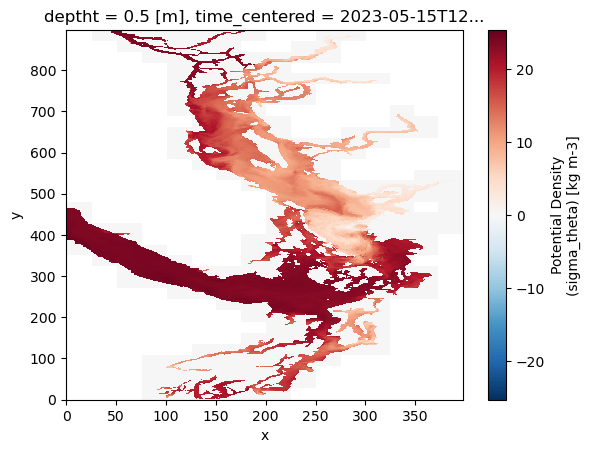

In [14]:
ds.sigma_theta.sel(time_counter="2023-05-15 12:30:00").sel(deptht=0, method="nearest").plot()

In [15]:
start_date_time, end_date_time = (
    arrow.get("2007-05-15 12:30:00"),
    arrow.get("2023-05-15 12:30:00"),
)
date_times = list(arrow.Arrow.range("year", start_date_time, end_date_time))

date_times

[<Arrow [2007-05-15T12:30:00+00:00]>,
 <Arrow [2008-05-15T12:30:00+00:00]>,
 <Arrow [2009-05-15T12:30:00+00:00]>,
 <Arrow [2010-05-15T12:30:00+00:00]>,
 <Arrow [2011-05-15T12:30:00+00:00]>,
 <Arrow [2012-05-15T12:30:00+00:00]>,
 <Arrow [2013-05-15T12:30:00+00:00]>,
 <Arrow [2014-05-15T12:30:00+00:00]>,
 <Arrow [2015-05-15T12:30:00+00:00]>,
 <Arrow [2016-05-15T12:30:00+00:00]>,
 <Arrow [2017-05-15T12:30:00+00:00]>,
 <Arrow [2018-05-15T12:30:00+00:00]>,
 <Arrow [2019-05-15T12:30:00+00:00]>,
 <Arrow [2020-05-15T12:30:00+00:00]>,
 <Arrow [2021-05-15T12:30:00+00:00]>,
 <Arrow [2022-05-15T12:30:00+00:00]>,
 <Arrow [2023-05-15T12:30:00+00:00]>]

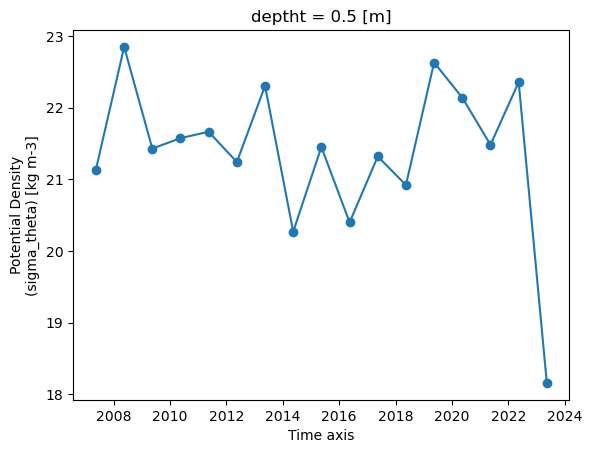

In [16]:
(ds.sigma_theta
    .sel(time_counter=[date_time.format("YYYY-MM-DD HH:mm:ss") for date_time in date_times])
    .sel(deptht=0, method="nearest")
    .sel(y=700, x=150)
    .plot(marker="o")
)